In [1]:
######## EE DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from statannot import add_stat_annotation
matplotlib.rcParams['pdf.fonttype'] = 42

### Get cEEs with strong activity in K-562 STARR-seq
df = pd.read_csv("/home/mouren/Data/valid_exp/summary_count_exonhancers_bilan.tsv", sep="\t", header=0)
df = df[~df['Log2FC'].str.contains('#', na=False)] # Remove rows with no log2FC values 
df["Log2FC"] = df["Log2FC"].str.replace(',', '.')
df["Input_STD"] = df["Input_STD"].str.replace(',', '.')
df["Log2FC"] = pd.to_numeric(df["Log2FC"])
df["count_sequence_AVO4Exonhmaxi4"] = pd.to_numeric(df["count_sequence_AVO4Exonhmaxi4"])
df["Input_STD"] = pd.to_numeric(df["Input_STD"])
# removes input count reads less than 500 and standard deviation above 20
filtered_df = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) & (df['Input_STD'] <= 20) & (df['Category2'] == "EEK")]
# Sort the DataFrame by Log2FC values
df_sorted = filtered_df.sort_values(by='Log2FC', ascending=True).reset_index(drop=True)

list_strong_ees = df_sorted.loc[df_sorted.index >= 2007, 'ID'].tolist() # take top 100 2007

### Load transcript-to-gene mapping
dic_transcript_gene = {}
with open("/home/mouren/Data/revisions/specificity/list_transript_gene_id_gencodeV41_all_proteincoding.tsv") as file:
    for line in file:
        tx, gene = line.strip().split()[:2]
        dic_transcript_gene[tx] = gene.split(".")[0]

### dic interaction
dic_interaction = {}
with open("/home/mouren/Data/revisions/specificity/robust_associations_exons_genes.txt") as file:
    for line in file:      
        if line.strip().split()[0] not in dic_interaction:
            dic_interaction["_".join((line.strip().split()[0]).split("_")[:3])] = [line.strip().split()[1]]
        else:
            dic_interaction["_".join((line.strip().split()[0]).split("_")[:3])].append(line.strip().split()[1])

### host gene to plot
host_to_plot = []
for i in list_strong_ees:
    tr = i.split("_")[0]
    if dic_transcript_gene[tr] not in host_to_plot:
        host_to_plot.append(dic_transcript_gene[tr])

### target gene to plot
target_to_plot = []
for i in list_strong_ees:
    tr = "_".join(i.split("_")[:3])
    if tr in dic_interaction:
        for j in dic_interaction[tr]:
            target_to_plot.append(j)

In [2]:
### Load ENCODE data from Expression Atlas
df = pd.read_csv('/home/mouren/Data/revisions/specificity/E-GEOD-26284-query-results.fpkms.tsv', sep='\t', header=0)
filtered_df = df.filter(regex='ID|A549|K562|GM12878', axis=1)
filtered_df2 = filtered_df.filter(regex='ID|long polyA', axis=1)
#filtered_df3 = filtered_df2.filter(regex='ID|nucleus', axis=1)
filtered_df3 = filtered_df2.filter(regex='ID|whole', axis=1)

filtered_df_host = filtered_df3[filtered_df3['Gene ID'].isin(host_to_plot)]
filtered_df_target = filtered_df3[filtered_df3['Gene ID'].isin(target_to_plot)]

genes_host = filtered_df_host.pop('Gene ID')
genes_target = filtered_df_target.pop('Gene ID')

In [3]:
# Define custom order and labels
#feature_order = ['nucleus, long polyA RNA, K562', 'nucleus, long polyA RNA, A549', 'nucleus, long polyA RNA, GM12878']
feature_order = ['whole cell, long polyA RNA, K562', 'whole cell, long polyA RNA, A549', 'whole cell, long polyA RNA, GM12878']

custom_labels = ['K-562', 'A-549', 'GM12878']

/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mouren/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does 

Wilcoxon apparié pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, A549: W = 345.0000, p = 5.2888e-01, n_pairs = 43
t-test apparié (optionnel) pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, A549: t = -0.1322, p = 8.9544e-01
Wilcoxon apparié pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, GM12878: W = 189.0000, p = 8.3286e-03, n_pairs = 41
t-test apparié (optionnel) pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, GM12878: t = 1.8162, p = 7.6834e-02
whole cell, long polyA RNA, K562 v.s. whole cell, long polyA RNA, A549: Custom statistical test, P_val:5.289e-01
whole cell, long polyA RNA, K562 v.s. whole cell, long polyA RNA, GM12878: Custom statistical test, P_val:8.329e-03


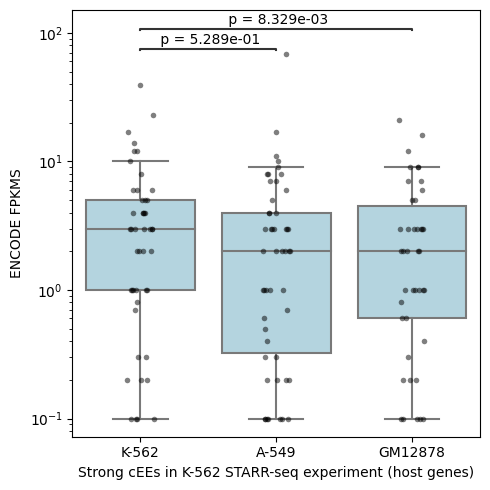

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, ttest_rel
# from statannot import add_stat_annotation  # déjà importé chez vous si besoin

# ── 1) Long format avec identifiant d'appariement ──────────────────────────────
# Chaque ligne d'origine constitue une paire entre colonnes (conditions)
filtered_df_host = filtered_df_host.copy()
filtered_df_host['PairID'] = np.arange(len(filtered_df_host))

df_long_host = filtered_df_host.melt(
    id_vars='PairID',            # <— conserve l’ID de paire
    var_name='Feature',
    value_name='Value'
)

# Assurer le type numérique
df_long_host['Value'] = pd.to_numeric(df_long_host['Value'], errors='coerce')

# ── 2) Plot ────────────────────────────────────────────────────────────────────
plt.figure(figsize=(5, 5))
ax = sns.boxplot(
    data=df_long_host, x='Feature', y='Value',
    color='lightblue', order=feature_order, showfliers=False
)
sns.stripplot(
    data=df_long_host, x='Feature', y='Value',
    color='black', jitter=True, alpha=0.5, size=4, order=feature_order
)

plt.yscale('log')

# ── 3) Paires à comparer (comme chez vous) ─────────────────────────────────────
valid_box_pairs = [
    ('whole cell, long polyA RNA, K562', 'whole cell, long polyA RNA, A549'),
    ('whole cell, long polyA RNA, K562', 'whole cell, long polyA RNA, GM12878'),
]

# ── 4) Tests appariés + impression des résultats ───────────────────────────────
paired_pvals = []
for group1, group2 in valid_box_pairs:
    a = (df_long_host[df_long_host['Feature'] == group1]
         [['PairID', 'Value']].rename(columns={'Value': 'v1'}))
    b = (df_long_host[df_long_host['Feature'] == group2]
         [['PairID', 'Value']].rename(columns={'Value': 'v2'}))

    # Fusion sur l'identifiant de paire pour ne garder que les paires observées dans les deux conditions
    merged = pd.merge(a, b, on='PairID', how='inner').dropna()

    if len(merged) == 0:
        print(f"Aucune paire disponible pour {group1} vs {group2}")
        paired_pvals.append(np.nan)
        continue

    # Wilcoxon signé-rang (apparié)
    try:
        # SciPy ≥ 1.11 (argument method)
        w_stat, w_p = wilcoxon(merged['v1'], merged['v2'], alternative='two-sided', method='auto')
    except TypeError:
        # Compatibilité SciPy plus ancien
        w_stat, w_p = wilcoxon(merged['v1'], merged['v2'])

    paired_pvals.append(w_p)
    print(f"Wilcoxon apparié pour {group1} vs {group2}: W = {w_stat:.4f}, p = {w_p:.4e}, n_pairs = {len(merged)}")

    # Optionnel : t-test apparié (au cas où vous souhaitez le voir aussi)
    try:
        t_stat, t_p = ttest_rel(merged['v1'], merged['v2'], nan_policy='omit')
        print(f"t-test apparié (optionnel) pour {group1} vs {group2}: t = {t_stat:.4f}, p = {t_p:.4e}")
    except Exception as e:
        print(f"t-test apparié impossible pour {group1} vs {group2}: {e}")

# ── 5) Annotation du graphique avec les p-values appariées calculées ───────────
# On fournit explicitement les p-values pour être sûr d’utiliser l’appariement correct.
add_stat_annotation(
    ax, data=df_long_host, x="Feature", y="Value",
    order=feature_order, box_pairs=valid_box_pairs,
    perform_stat_test=False,          # on n’exécute pas le test interne
    pvalues=paired_pvals,             # on injecte nos p-values appariées
    text_format='full', loc='inside', verbose=1, comparisons_correction=None
)

# ── 6) Finition du plot ────────────────────────────────────────────────────────
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.ylabel("ENCODE FPKMS")
plt.xlabel("Strong cEEs in K-562 STARR-seq experiment (host genes)")
plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/revisions/specificity_test/rev_1_pt4_starr_host.pdf",
            format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/revisions/specificity_test/rev_1_pt4_starr_host.png",
            format="png", bbox_inches="tight", dpi=450)
plt.show()







/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mouren/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mouren/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does 

Wilcoxon apparié pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, A549: W = 50.0000, p = 2.0608e-01, n_pairs = 20
t-test apparié (optionnel) pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, A549: t = 0.6064, p = 5.5146e-01
Wilcoxon apparié pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, GM12878: W = 10.0000, p = 1.3076e-02, n_pairs = 17
t-test apparié (optionnel) pour whole cell, long polyA RNA, K562 vs whole cell, long polyA RNA, GM12878: t = 1.8963, p = 7.6126e-02
whole cell, long polyA RNA, K562 v.s. whole cell, long polyA RNA, A549: Custom statistical test, P_val:2.061e-01
whole cell, long polyA RNA, K562 v.s. whole cell, long polyA RNA, GM12878: Custom statistical test, P_val:1.308e-02


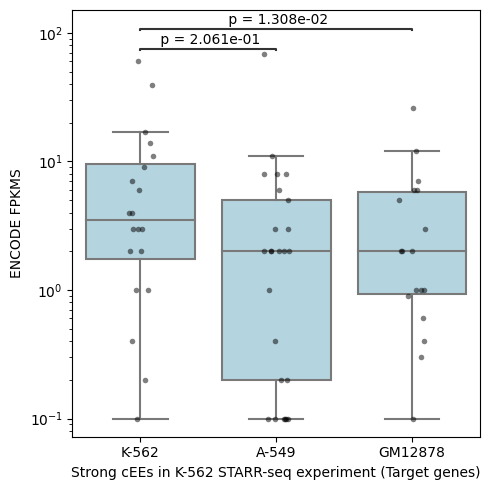

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, ttest_rel
# from statannot import add_stat_annotation  # déjà importé chez vous si besoin

# ── 1) Long format avec identifiant d'appariement ──────────────────────────────
# Chaque ligne d'origine constitue une paire entre colonnes (conditions)
filtered_df_target = filtered_df_target.copy()
filtered_df_target['PairID'] = np.arange(len(filtered_df_target))

df_long_target = filtered_df_target.melt(
    id_vars='PairID',            # <— conserve l’ID de paire
    var_name='Feature',
    value_name='Value'
)

# Assurer le type numérique
df_long_target['Value'] = pd.to_numeric(df_long_target['Value'], errors='coerce')

# ── 2) Plot ────────────────────────────────────────────────────────────────────
plt.figure(figsize=(5, 5))
ax = sns.boxplot(
    data=df_long_target, x='Feature', y='Value',
    color='lightblue', order=feature_order, showfliers=False
)
sns.stripplot(
    data=df_long_target, x='Feature', y='Value',
    color='black', jitter=True, alpha=0.5, size=4, order=feature_order
)

plt.yscale('log')

# ── 3) Paires à comparer (comme chez vous) ─────────────────────────────────────
valid_box_pairs = [
    ('whole cell, long polyA RNA, K562', 'whole cell, long polyA RNA, A549'),
    ('whole cell, long polyA RNA, K562', 'whole cell, long polyA RNA, GM12878'),
]

# ── 4) Tests appariés + impression des résultats ───────────────────────────────
paired_pvals = []
for group1, group2 in valid_box_pairs:
    a = (df_long_target[df_long_target['Feature'] == group1]
         [['PairID', 'Value']].rename(columns={'Value': 'v1'}))
    b = (df_long_target[df_long_target['Feature'] == group2]
         [['PairID', 'Value']].rename(columns={'Value': 'v2'}))

    # Fusion sur l'identifiant de paire pour ne garder que les paires observées dans les deux conditions
    merged = pd.merge(a, b, on='PairID', how='inner').dropna()

    if len(merged) == 0:
        print(f"Aucune paire disponible pour {group1} vs {group2}")
        paired_pvals.append(np.nan)
        continue

    # Wilcoxon signé-rang (apparié)
    try:
        # SciPy ≥ 1.11 (argument method)
        w_stat, w_p = wilcoxon(merged['v1'], merged['v2'], alternative='two-sided', method='auto')
    except TypeError:
        # Compatibilité SciPy plus ancien
        w_stat, w_p = wilcoxon(merged['v1'], merged['v2'])

    paired_pvals.append(w_p)
    print(f"Wilcoxon apparié pour {group1} vs {group2}: W = {w_stat:.4f}, p = {w_p:.4e}, n_pairs = {len(merged)}")

    # Optionnel : t-test apparié (au cas où vous souhaitez le voir aussi)
    try:
        t_stat, t_p = ttest_rel(merged['v1'], merged['v2'], nan_policy='omit')
        print(f"t-test apparié (optionnel) pour {group1} vs {group2}: t = {t_stat:.4f}, p = {t_p:.4e}")
    except Exception as e:
        print(f"t-test apparié impossible pour {group1} vs {group2}: {e}")

# ── 5) Annotation du graphique avec les p-values appariées calculées ───────────
# On fournit explicitement les p-values pour être sûr d’utiliser l’appariement correct.
add_stat_annotation(
    ax, data=df_long_target, x="Feature", y="Value",
    order=feature_order, box_pairs=valid_box_pairs,
    perform_stat_test=False,          # on n’exécute pas le test interne
    pvalues=paired_pvals,             # on injecte nos p-values appariées
    text_format='full', loc='inside', verbose=1, comparisons_correction=None
)

# ── 6) Finition du plot ────────────────────────────────────────────────────────
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.ylabel("ENCODE FPKMS")
plt.xlabel("Strong cEEs in K-562 STARR-seq experiment (Target genes)")
plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/revisions/specificity_test/rev_1_pt4_starr_target.pdf",
            format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/revisions/specificity_test/rev_1_pt4_starr_target.png",
            format="png", bbox_inches="tight", dpi=450)
plt.show()
